<a href="https://colab.research.google.com/github/PHYRA47/Biometrics-II/blob/main/Biometrics%20Skills%20-%20Amine%20Nait-Ali/skill1_Face_Recognition_for_Verification/biometrics_skill_1_Face_Recognition_for_Verification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

<center><h1></h></center>

<center><h1> Skills 1: Face Recognition for Verification </h></center>
<center>
    <img src="https://le-cdn.website-editor.net/s/9d802a9e77324ea49af5974d51d75a28/dms3rep/multi/opt/Logo_EMJM_iPSRS_Black_GOOD-1920w.png?Expires=1736586093&Signature=Tz0tVLA~2vH-R-73-kTHNpYLUa~ZLpFyKAavHnyQwgpiMaLA9FL6~xaODYtWo9WniM1a-Ryql7tpJU5mmRwy41fRsW5dOk8FyOOKhZM4wc85MgdHXhgTGgc0PkjDISHh4ZJ243jRSf6bDjcC3uZvN2OyuOjSUnAHqyO~fQw49I~j~eDeafqToDrILwk92X2jz-YLw8DCtrtQh6EVyyzMa5BsuFWQv7KT5oJGq~WYgw9qwrXh4TtJOuTIt-h~Bh5G6QJCGdu8a7AS8QTXAL7GElVWFXTnD9A3D15H1KlwXGeq8~7vIIk1n~z0--ndQzXr7~kWo45nqCNcj2WDRvMKtg__&Key-Pair-Id=K2NXBXLF010TJW", width=250>
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT7qOQzhswn5yYVpbD6SL8SQtKuZT4IBwf8tg&s", width=150>
</center>

<center>Fromsa Teshome Negasa </center>
<center>Photonics for Security, Reliability, and Safety (PSRS)</center>
<center>Biometrics Course Assignment</center>
<center>Prof. Amine Nait-Ali, Instructor</center>
<center>6<sup>th</sup> January 2025</center>

<center><h1></h></center>

---

# 1 Imports and Environment Setup

## Import Modules and Setup

In [ ]:
#@title Authenticate with Google Acoount and do imports { display-mode: "form" }
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

import os

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#@title Import standard machine learning and data science modules
import numpy as np
import pandas as pd
import cv2
import random
import os
import shutil
from tqdm import tqdm
from glob import glob
import math
from functools import partial

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

# Import zoom function
# from keras_preprocessing.image import random_zoom


from PIL import Image
from IPython.display import display
from matplotlib.image import pil_to_array, imread
from matplotlib import pyplot as plt

np.random.seed(42)
random.seed(42)

tqdm.pandas()

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
#@title Import Keras modules
import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory, array_to_img, img_to_array, load_img, plot_model
from keras.layers import RandomZoom
from keras import layers
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input, Lambda, AveragePooling2D, Activation, PReLU, ReLU, Add, GlobalAveragePooling2D
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, TerminateOnNaN
from keras.optimizers import SGD, Adam
import keras.backend as K

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
#@title Helper functions: image processing and useful plots { display-mode: "form" }
# Google Drive upload/download helpers
def drive_upload_file(full_filename):
  filename = os.path.basename(full_filename)
  file_to_upload = drive.CreateFile({'title': filename})
  file_to_upload.SetContentFile(full_filename)
  file_to_upload.Upload()

def drive_download_file(file_id, local_path='./'):
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.FetchMetadata()
  fn = downloaded.metadata.get('originalFilename')
  full_fn = os.path.join(local_path, fn)
  downloaded.GetContentFile(full_fn)
  return full_fn

# Dataset reading helpers
def filter_df(df, min_images_count=0):
  df = df.sort_values('images', ascending=False)
  return df[df.images >= min_images_count]

# Undo ImageNet preprocessing to show images from batch generator
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)  # RGB
de_preproc = lambda x: np.clip((x[..., ::-1]+vgg_mean)/255., 0, 1)

# Visualization helpers
# Images root dir
img_root_dir = 'input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# equal probabilities
equal_apriori = 0.5

# number of thresholds
num_thresholds = 100
# generate a list of  n thresholds between 0.0 and 1.0
thresholds = [i/num_thresholds for i in range(num_thresholds)]

def plot_scores(imposter, genuine):
  """ Plot the scores of the genuine and imposters """

  plt.figure(figsize=(10, 6))

  # Draws a histogram to show score frequencies with values.
  plt.hist(imposter, alpha=0.50, label='Imposter', color='red')
  plt.hist(genuine, alpha=0.50, label='Genuine', color='green')

  # Adding labels and titles to the plot
  plt.xlabel('Score')
  plt.ylabel('Frequency')
  # plt.title('Distribution of Genuine and Imposter Scores')
  plt.grid(True)

  # draw the key/legend
  plot_legends()

  # show the plot
  show_plot()

def calculate_cost(imposter, genuine):
  """ For both users, calculates a confusion matrix and then calculates cost per threshold """

  # generate n number of thresholds

  far = []
  frr = []
  cost = []

  # for each threshold, calculate confusion matrix.
  for t in thresholds:

    FP = 0
    FN = 0
    TP = 0
    TN = 0

    # go through imposters
    for score in imposter:

      if score >= t:
        # imposter passes as a genuine user
        FP += 1
      else:
        # imposter correctly rejected
        TN += 1

    for score in genuine:
      if score >= t:
        # genuine user correctly identified
        TP += 1
      else:
        # genuine user incorrectly rejected
        FN += 1

    far_current = float(FP) / float(len(imposter))
    frr_current = float(FN) / float(len(genuine))

    # calculate our false accept rate(FAR) and add to list
    far.append(far_current)

    # calculate our false reject rate(FRR) and add to list
    frr.append(frr_current)

  return far, frr

def plot_DET_with_EER(far, frr, far_optimum, frr_optimum):
  """ Plots a DET curve with the most suitable operating point based on threshold values"""

  # Plot the DET curve based on the FAR and FRR values
  plt.plot(far, frr, linestyle="--", linewidth=4, label="DET Curve")

  # Plot the optimum point on the DET Curve
  plt.plot(far_optimum,frr_optimum, "ro", label="Suitable Operating Point")

  # Draw the default DET Curve from 1-1
  plt.plot([1.0,0.0], [0.0,1.0],"k--")

  # Draws the key/legend
  plot_legends()

  # Displays plots
  show_plot()

"""
def plot_DET_with_EER(far, frr, addedPlots=None):
    plt.figure(figsize=(10, 6))
    plt.plot(far, frr, linestyle="--", color='blue', linewidth=4, label="DET Curve")
    if addedPlots is not None:
        addedPlots()
    plt.xlabel('False Acceptance Rate (FAR)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title('Detection Error Tradeoff (DET) curve')
    plt.legend()
    plt.grid()
    plt.show()
"""

def plot_FAR_vs_FRR(far, frr, eer_threshold):

  plt.figure(figsize=(10, 6))

  # Plot FAR and FRR
  plt.plot(thresholds, far, 'g-', label='FAR', color='red')
  plt.plot(thresholds, frr, 'b-', label='FRR', color='blue')
  plt.axvline(eer_threshold, color='green', linestyle='--', label=f'EER = {eer:.4f} at Threshold = {eer_threshold:.2f}')


  plt.xlabel('Threshold'), plt.ylabel('Error Rate')
  # plt.title('FAR and FRR vs Threshold')
  # Draws the key/legend
  plot_legends(), plt.grid()

  # Displays plots
  show_plot()
"""
def find_EER(far, frr):
  # Returns the most optimal FAR and FRR values

  # The lower the equal error rate value,
  # the higher the accuracy of the biometric system.

  # smallest value is most accurate
  far = np.array(far)
  frr = np.array(frr)
  delta = np.abs(far - frr)
  t = np.argmin(delta)
  far_optimum = far[t]
  frr_optimum = frr[t]
  threshold_optimum = thresholds[t]

  return far_optimum, frr_optimum, threshold_optimum

"""
def find_EER(far_values, frr_values, thresholds):
    # Calculate the absolute differences between FAR and FRR
    delta = np.abs(np.array(far_values) - np.array(frr_values))

    # Find the index where the difference is minimum (EER point)
    eer_index = np.argmin(delta)

    # Return the FAR at EER, FRR at EER, and the threshold at EER
    return far_values[eer_index], frr_values[eer_index], thresholds[eer_index]

def plot_legends():
  legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
  legend.get_frame().set_facecolor('#ffffff')

def show_plot():
  plt.show()

def extract_template(image_paths, model, target_size=(224, 224), batch_size=32):
  """
  Extract image template from a filename list using a Keras model and tf.data.Dataset.

  Args:
    image_paths: A list of image filenames.
    model: Keras model with a predict method.
    target_size: Tuple (height, width) for resizing images.
    batch_size: Batch size for prediction.

  Returns:
    A list of model prediction results.
  """

  def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = zoom_image(img)
    # img = preprocess_input(img)
    return img

  zoom_image = keras.Sequential([
    keras.layers.RandomZoom((-0.5, -0.5)),
    keras.layers.Resizing(target_size[0], target_size[1]),
  ])
  dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  predictions = model.predict(dataset)

  return predictions.tolist()

def name_to_image_path(root_dir, name, image_num):
  return f'{root_dir}/{name}/{name}_{image_num:04d}.jpg'

def evaluate_model_alex(model, pairs_file='./input/lfw-dataset/course-pairsDevTest.csv'):
  # Cut our model at the 'embedding' layer level and convert it to template extractor
  embedding_out = model.get_layer('face_embedding').output
  template_extrator = Model(inputs=[input_layer], outputs=[embedding_out])

  # Read pairs matched and mismatched for dev dataset
  print('Preparing stats from dev set')
  test_pairs = pd.read_csv(pairs_file)
  test_pairs['img_fn1'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name1'], row['imagenum1']), axis=1)
  test_pairs['img_fn2'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name2'], row['imagenum2']), axis=1)

  # Apply the template model to all images
  test_pairs['template1'] = extract_template(test_pairs['img_fn1'], template_extrator, target_size)
  test_pairs['template2'] = extract_template(test_pairs['img_fn2'], template_extrator, target_size)
  test_pairs['cos_distance'] = test_pairs.apply(lambda row: distance.cosine(row['template1'], row['template2'])/2., axis=1)  # cos distance rescaled to (0,1)

  match_scores = test_pairs[test_pairs.match_pair==1]['cos_distance']
  mismatch_scores = test_pairs[test_pairs.match_pair==0]['cos_distance']

  # Plot model's stats
  genuine = match_scores.values
  imposter = mismatch_scores.values

  far, frr = calculate_cost(imposter, genuine)
  far_optimum, frr_optimum, err_threshold = find_EER(far, frr)

  # Calculate the EER value
  eer = (far_optimum + frr_optimum) / 2
  print(f"Equal Error Rate (EER): {eer:.4f}")

  plot_scores(imposter, genuine)
  plot_DET_with_EER(far, frr, far_optimum, frr_optimum)
  plot_FAR_vs_FRR(far, frr, err_threshold)
  print(f'EER at threshold: {err_threshold}')

  # Now let's calculate accuracy for test set
  test_pairs['pred_match_pair'] = test_pairs['cos_distance'] < err_threshold
  test_pairs['pred_match_pair'] = test_pairs['pred_match_pair'].astype(int)

  print(f'At threshold {err_threshold} accuracy score is {accuracy_score(test_pairs.match_pair.values, test_pairs.pred_match_pair.values):.4f}')
  return test_pairs

# 2 Dataset preparation

## Download and unpack LFW files

In [ ]:
# Prepare Labelled Faces in the Wild dataset
!mkdir -p input/lfw-dataset

# Download LFW file (drive id is '14ra9GYFzdyeubZ5qtSDaDAbFDKPCjdAD')
file_id = '14ra9GYFzdyeubZ5qtSDaDAbFDKPCjdAD'
drive_download_file(file_id, local_path='./input/')

# Unpack zip files
!7z x ./input/lfw-dataset.zip -o./input/lfw-dataset -aoa
!7z x ./input/lfw-dataset/lfw-deepfunneled.zip -o./input/lfw-dataset/lfw-deepfunneled -aoa

# Clean temp files
!rm -r ./input/lfw-dataset/lfw-deepfunneled/__MACOSX/ ./input/lfw-dataset/__MACOSX/



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./input/                  1 file, 116495068 bytes (112 MiB)

Extracting archive: ./input/lfw-dataset.zip
--
Path = ./input/lfw-dataset.zip
Type = zip
Physical Size = 116495068

  0%     10% 25 - lfw-deepfunneled.zip                               21% 25 - lfw-deepfunneled.zip                               30% 25 - lfw-deepfunneled.zip                               38% 25 - lfw-deepfunneled.zip                               47% 25 - lfw-deepfunneled.zip

In [ ]:
!ls -lh **/**/**

-rw-r--r-- 1 root root 207K Nov 24  2018 input/lfw-dataset/course-pairs.csv
-rw-r--r-- 1 root root  35K Nov 24  2018 input/lfw-dataset/course-pairsDevTest.csv
-rwxr-xr-x 1 root root  99K May 17  2018 input/lfw-dataset/lfw_allnames.csv
-rwxr-xr-x 1 root root 121M May 17  2018 input/lfw-dataset/lfw-deepfunneled.zip
-rwxr-xr-x 1 root root 8.0K May 17  2018 input/lfw-dataset/lfw_readme.txt
-rwxr-xr-x 1 root root 9.7K May 17  2018 input/lfw-dataset/matchpairsDevTest.csv
-rwxr-xr-x 1 root root  22K May 17  2018 input/lfw-dataset/matchpairsDevTrain.csv
-rwxr-xr-x 1 root root  17K May 17  2018 input/lfw-dataset/mismatchpairsDevTest.csv
-rwxr-xr-x 1 root root  37K May 17  2018 input/lfw-dataset/mismatchpairsDevTrain.csv
-rwxr-xr-x 1 root root 161K May 17  2018 input/lfw-dataset/pairs.csv
-rwxr-xr-x 1 root root  99K May 17  2018 input/lfw-dataset/people.csv
-rwxr-xr-x 1 root root  30K May 17  2018 input/lfw-dataset/peopleDevTest.csv
-rwxr-xr-x 1 root root  69K May 17  2018 input/lfw-dataset/peop

## Copy images into train-validation directories

In [ ]:
# Load LFW labels and keep only people with > min_images_count images
df_train = filter_df(pd.read_csv('./input/lfw-dataset/peopleDevTrain.csv'), min_images_count=20)
df_train.head(), len(df_train)

(               name  images
 1328  George_W_Bush     530
 743    Colin_Powell     236
 3842     Tony_Blair     144
 270    Ariel_Sharon      77
 1543    Hugo_Chavez      71,
 46)

In [ ]:
# Prepare a list of all images for names in train list
all_train = []
for name in df_train.name.values:
    imgs_for_name = glob(f'./input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name}/*.jpg')
    all_train += [{'name': name, 'filename': fn} for fn in imgs_for_name]

# Train-validation split
df_train = pd.DataFrame(all_train)
df_train, df_val = train_test_split(df_train, train_size=0.8, stratify=df_train.name.values)

In [ ]:
# Check split lenght
len(df_train), len(df_val)

(1896, 474)

In [ ]:
# Create directories structure
root_path = 'input/lfw-train-test-split'

weights_path = './weights'
logs_path = f'{root_path}/logs'
os.makedirs(weights_path, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)

train_path = f'{root_path}/train/'
validation_path = f'{root_path}/validation/'

In [ ]:
# Make 'name' directories in the train-valid dirs
shutil.rmtree(train_path, ignore_errors=True)
shutil.rmtree(validation_path, ignore_errors=True)
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)

for name in df_train.name.values:
    os.makedirs(os.path.join(train_path, name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, name), exist_ok=True)

print(f"Created directories: \n{train_path}, \n{validation_path}")

Created directories: 
input/lfw-train-test-split/train/, 
input/lfw-train-test-split/validation/


In [ ]:
# Copy to train dir
for i, row in tqdm(df_train.iterrows()):
    shutil.copy(row['filename'], os.path.join(train_path, row['name']))

# Copy to validation dir
for i, row in tqdm(df_val.iterrows()):
    shutil.copy(row['filename'], os.path.join(validation_path, row['name']))

1896it [00:00, 3348.55it/s]
474it [00:00, 3167.33it/s]


input/lfw-train-test-split/train/Ariel_Sharon/Ariel_Sharon_0075.jpg 250 250


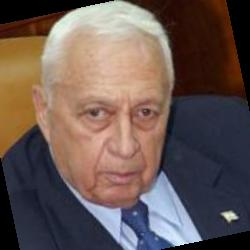

input/lfw-train-test-split/train/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg 250 250


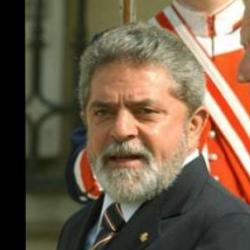

input/lfw-train-test-split/train/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0037.jpg 250 250


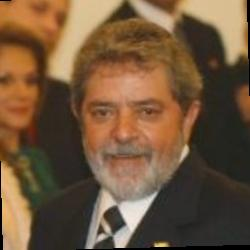

In [ ]:
# Show some images
imgs_fn = glob(f'{train_path}/**/*.jpg', recursive=True)
for fn in np.random.choice(imgs_fn, size=3):
    img = Image.open(fn)
    print(fn, img.height, img.width)
    display(img)

# 3 Train models

## Image data generators

In [ ]:
!ls {train_path}/*/*.jpg

input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0001.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0002.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0003.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0004.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0005.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0006.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0007.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0008.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0009.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0011.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0012.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0013.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0014.jpg

In [ ]:
# Data generators
batch_size = 32*3
target_size = (128, 128)
n_count = 3

In [ ]:
train_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.45, -0.55)),
    keras.layers.RandomFlip(mode="horizontal"),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.Resizing(target_size[0], target_size[1]),
    # keras.layers.Rescaling(scale=1./255)
])

valid_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.5, -0.5)),
    keras.layers.Resizing(target_size[0], target_size[1]),
    # keras.layers.Rescaling(scale=1./255)
])

In [ ]:
def preprocess(image, label, img_aug):
    image = img_aug(image)
    return image, label

In [ ]:
# Train data generator
train_dataset =  keras.utils.image_dataset_from_directory(
      train_path,
      labels='inferred',
      label_mode='categorical',
      batch_size=batch_size,
      image_size=(256, 256)
  )

n_classes = len(train_dataset.class_names)
augment_train = partial(preprocess, img_aug=train_img_aug)

# # More real-life version
# train_gen = (train_dataset
#             .cache()
#             .shuffle(100)
#             .map(augment_train, num_parallel_calls=AUTOTUNE)
#             .prefetch(AUTOTUNE)
#             .repeat(n_count)
#             )

# Study-purpose version
train_gen = (train_dataset
            .map(augment_train, num_parallel_calls=AUTOTUNE)
            .repeat(n_count)
            .cache()
            .shuffle(100)
            .prefetch(AUTOTUNE)
            )

# Validation data generator
valid_dataset =  keras.utils.image_dataset_from_directory(
      validation_path,
      labels='inferred',
      label_mode='categorical',
      batch_size=1,
      image_size=(256, 256)
  )
augment_valid = partial(preprocess, img_aug=valid_img_aug)

valid_gen = (valid_dataset
            .map(augment_valid, num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE)
            .cache()
            )

Found 1896 files belonging to 46 classes.
Found 474 files belonging to 46 classes.


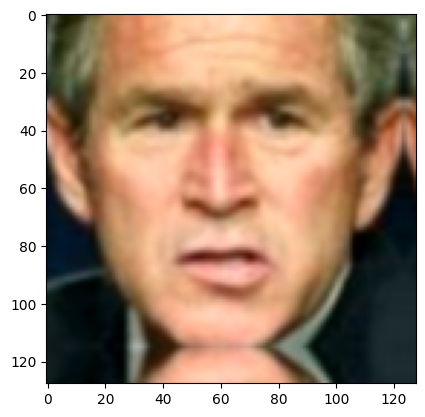

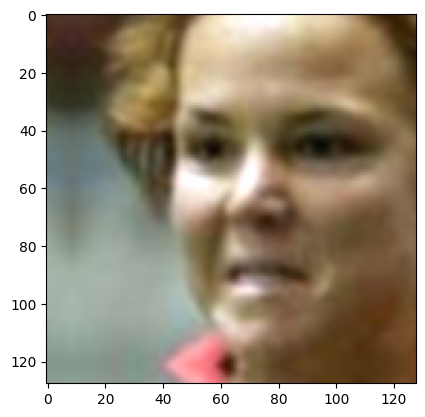

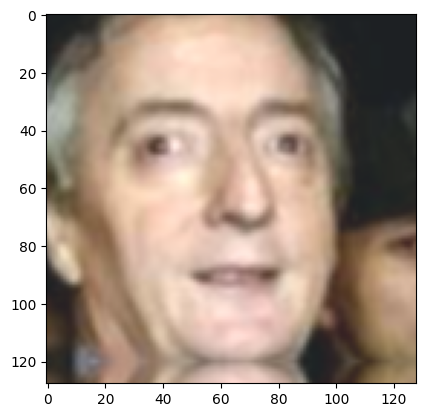

<Figure size 640x480 with 0 Axes>

In [ ]:
# Check that train data generator is working
batch_x, batch_y = next(iter(train_gen.take(1)))
for x in batch_x.numpy()[:3]:
    plt.imshow(x/255.); plt.figure()

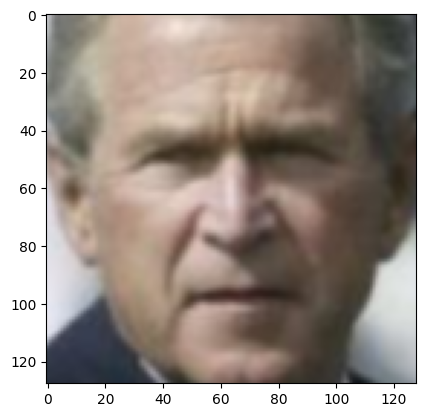

<Figure size 640x480 with 0 Axes>

In [ ]:
# Validation generator
batch_x, batch_y = next(iter(valid_gen))
for x in batch_x:
  plt.imshow(x/255.); plt.figure()

## Common training parameters


In [ ]:
embedding_size = 128  # Try to change this: 64, 128, 512 ?
dropout_rate = 0.5  # Try to change this: 0.5, 0.9 ?
nb_epochs = 10  # Try to change this: 10, 50, 100 ?

# 3.2  `Xception`




In [ ]:
from keras.applications.xception import Xception

In [ ]:
# Set up learning rate and automatic LR decreasing
LR = 3e-4
lrate = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)
optimizer = Adam(learning_rate=LR)
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

In [ ]:
# Save best model weights
save_model = ModelCheckpoint(f'{weights_path}/custom-Xception.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [ ]:
# Define the input layer
input_shape = target_size + (3,)
input_layer = Input(shape=input_shape)
input_layer = layers.Lambda(preprocess_input)(input_layer)

In [ ]:
# Load the VGG19 model without the top layers
base_model = Xception(
    include_top=False,
    weights=None,
    input_tensor=input_layer,
    input_shape=None,
    pooling="max",
    classes=46,
    classifier_activation="softmax",
    name="xception"
)

In [ ]:
# Get the output of the base model
x = base_model.output

# Flatten the output of the base model
x = layers.Flatten()(x)

x = Dense(embedding_size)(x)
x = ReLU()(x)
x = BatchNormalization(name='face_embedding')(x)
x = Dropout(dropout_rate)(x)

output_layer = Dense(n_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=[input_layer], outputs=[output_layer], name='Xception')

In [ ]:
model.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model.summary()

Model: "Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_13CLONE      │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ keras_tensor_13CLONE[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[1][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[1][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[1][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[1][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[1][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[1][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[1]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[1… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[1][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[1]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,130,198 (80.61 MB)

 Trainable params: 21,075,414 (80.40 MB)

 Non-trainable params: 54,784 (214.00 KB)

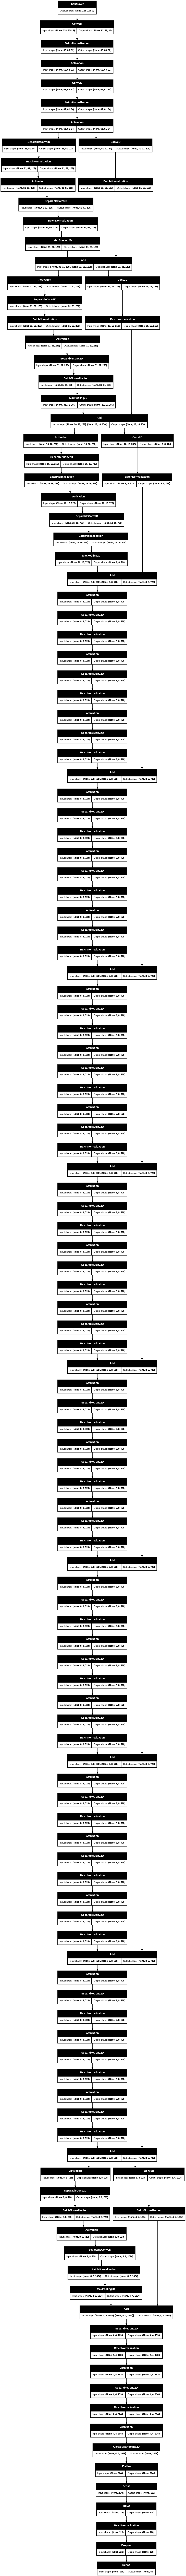

In [ ]:
!mkdir -p model

plot_model(
    model,
    to_file='./model/xception.png',
    show_shapes=True,
    dpi=70)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 16.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


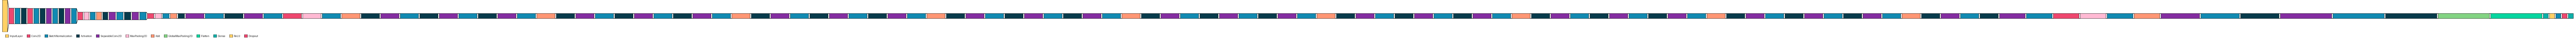

In [ ]:
!pip install visualkeras

from visualkeras import layered_view

layered_view(model,
            to_file='./model/xception_model.png',
            legend=True,
            scale_xy=1.0,
            legend_text_spacing_offset=1,
            draw_volume=False,
            spacing=5)

In [ ]:
# Train model
hist = model.fit(train_gen.repeat(10),
                epochs=nb_epochs,
                validation_data=valid_gen,
                callbacks=[lrate, save_model])

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.5352 - loss: 2.1261
Epoch 1: val_loss improved from inf to 5.77941, saving model to ./weights/custom-Xception.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 354s 493ms/step - accuracy: 0.5357 - loss: 2.1242 - val_accuracy: 0.0127 - val_loss: 5.7794 - learning_rate: 3.0000e-04
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 1.0000 - loss: 0.0365
Epoch 2: val_loss improved from 5.77941 to 1.35331, saving model to ./weights/custom-Xception.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 320s 452ms/step - accuracy: 1.0000 - loss: 0.0364 - val_accuracy: 0.6730 - val_loss: 1.3533 - learning_rate: 3.0000e-04
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 1.0000 - loss: 0.0154
Epoch 3: val_loss improved from 1.35331 to 1.32037, saving model to ./weights/custom-Xception.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 318s 445ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.6624 - val_loss: 1.3204 - lear

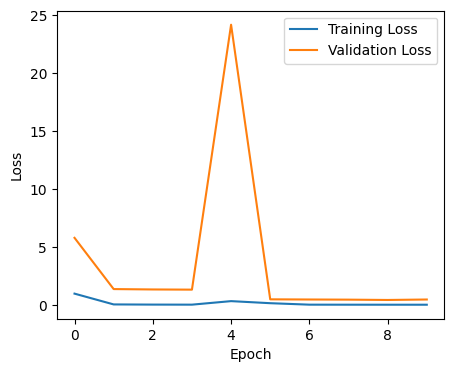

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
#plt.title(f'Training and Validation Loss for {model.name}') # Add model name as title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save(f'./model/xception.keras')

# Evaluation

In [ ]:
#@title Evalute model performance with Alexandars Metrices { display-mode: "form" }
pairs_df = evaluate_model_alex(model)

ValueError: The name "keras_tensor_13CLONE" is used 2 times in the model. All operation names should be unique.

In [ ]:
#@title Evalute model performance with Library Metrices { display-mode: "form" }
def evaluate_model(model, pairs_file='./input/lfw-dataset/course-pairsDevTest.csv'):
  # Cut our model at the 'embedding' layer level and convert it to template extractor
  embedding_out = model.get_layer('face_embedding').output
  # Instead of creating a function, create a Model instance
  template_extrator = Model(inputs=model.inputs, outputs=embedding_out)

  # Read pairs matched and mismatched for dev dataset
  print('Preparing stats from dev set')
  test_pairs = pd.read_csv(pairs_file)
  test_pairs['img_fn1'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name1'], row['imagenum1']), axis=1)
  test_pairs['img_fn2'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name2'], row['imagenum2']), axis=1)

  # Apply the template model to all images
  test_pairs['template1'] = extract_template(test_pairs['img_fn1'], template_extrator, target_size)
  test_pairs['template2'] = extract_template(test_pairs['img_fn2'], template_extrator, target_size)
  test_pairs['cos_distance'] = test_pairs.apply(lambda row: distance.cosine(row['template1'], row['template2'])/2., axis=1)  # cos distance rescaled to (0,1)

  match_scores = test_pairs[test_pairs.match_pair==1]['cos_distance']
  mismatch_scores = test_pairs[test_pairs.match_pair==0]['cos_distance']

  # Plot model's stats
  genuine = match_scores.values
  imposter = mismatch_scores.values

  return genuine, imposter

def calculate_far_frr(thresholds, imposter_scores, genuine_scores):
    # Initialize lists to store FAR and FRR values
    far_values = []
    frr_values = []

    # Loop through each threshold and calculate FAR and FRR
    for threshold in thresholds:
        # False Acceptances: Imposter scores exceeding the threshold
        false_acceptances = np.sum(imposter_scores > threshold)
        # False Rejections: Genuine scores below the threshold
        false_rejections = np.sum(genuine_scores < threshold)

        # Total Imposter and Genuine attempts
        total_imposter_attempts = len(imposter_scores)
        total_genuine_attempts = len(genuine_scores)

        # Calculate FAR and FRR
        far = false_acceptances / total_imposter_attempts if total_imposter_attempts != 0 else 0
        frr = false_rejections / total_genuine_attempts if total_genuine_attempts != 0 else 0

        far_values.append(far)
        frr_values.append(frr)

    return far_values, frr_values

def find_EER(far_values, frr_values, thresholds):
    # Calculate the absolute differences between FAR and FRR
    delta = np.abs(np.array(far_values) - np.array(frr_values))

    # Find the index where the difference is minimum (EER point)
    eer_index = np.argmin(delta)

    # Return the FAR at EER, FRR at EER, and the threshold at EER
    return far_values[eer_index], frr_values[eer_index], thresholds[eer_index]

def plot_DET_curve(far_values, frr_values, addedPlots=None):
    plt.figure(figsize=(10, 6))
    plt.plot(far_values, frr_values, linestyle="--", color='blue', linewidth=4, label="DET Curve")
    if addedPlots is not None:
        addedPlots()
    plt.xlabel('False Acceptance Rate (FAR)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title('Detection Error Tradeoff (DET) curve')
    plt.legend()
    plt.grid()
    plt.show()

def addedPlots():
    plt.plot(far_opt, frr_opt, 'ro', label="EER Point")
    plt.plot([1.0, 0.0], [0.0, 1.0], "k--")  # Draw the default DET Curve from 1-1

In [ ]:
genuine_scores, imposter_scores = evaluate_model(model, pairs_file='./input/lfw-dataset/course-pairsDevTest.csv')

genuine_mean = genuine_scores.mean()
genuine_std_dev = genuine_scores.std()
imposter_mean = imposter_scores.mean()
imposter_std_dev = imposter_scores.std()

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step


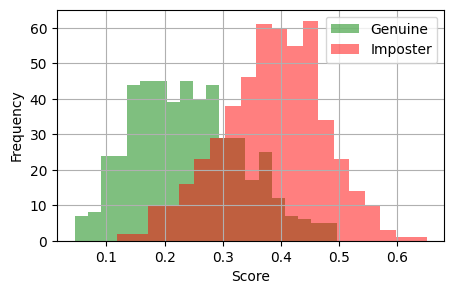

(None, <matplotlib.legend.Legend at 0x7b279d3e5720>, None)

In [ ]:
# Visualize the distribution of scores
plt.figure(figsize=(5, 3))
plt.hist(genuine_scores, bins=20, alpha=0.5, label='Genuine', color='green')
plt.hist(imposter_scores, bins=20, alpha=0.5, label='Imposter', color='red')
# plt.title("Distribution of Genuine and Imposter Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(), plt.legend(), plt.show()

In [ ]:
# Display the statistics

print(f"Genuine Scores:")
print(f"  Mean Score:           {genuine_mean:.4f}")
print(f"  Standard Deviation:   {genuine_std_dev:.4f}\n")

print(f"Imposter Scores:")
print(f"  Mean Score:           {imposter_mean:.4f}")
print(f"  Standard Deviation:   {imposter_std_dev:.4f}")

Genuine Scores:
  Mean Score:           0.2394
  Standard Deviation:   0.0932

Imposter Scores:
  Mean Score:           0.3850
  Standard Deviation:   0.0891


In [ ]:
# Define thresholds from 0 to 1 with a step size of 0.01
thresholds = np.arange(0, 1.01, 0.01)

In [ ]:
# Calculate FAR and FRR values for the given thresholds
far_values, frr_values = calculate_far_frr(thresholds, imposter_scores, genuine_scores)

# Find the EER (Equal Error Rate) point
far_opt, frr_opt, eer_threshold = find_EER(far_values, frr_values, thresholds)

# Calculate the EER value
eer = (far_opt + frr_opt) / 2
print(f"Equal Error Rate (EER): {eer:.4f}")

Equal Error Rate (EER): 0.7920


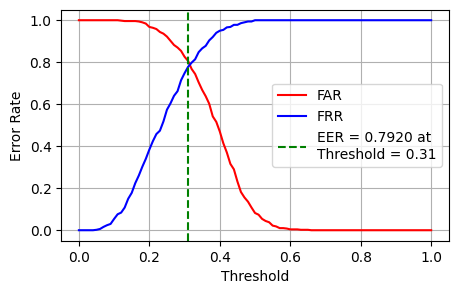

(<matplotlib.legend.Legend at 0x7b27a43a23e0>, None, None)

In [ ]:
# Plot FAR and FRR against thresholds
plt.figure(figsize=(5, 3))
plt.plot(thresholds, far_values, label='FAR', color='red')
plt.plot(thresholds, frr_values, label='FRR', color='blue')
plt.axvline(eer_threshold, color='green', linestyle='--', label=f'EER = {eer:.4f} at \nThreshold = {eer_threshold:.2f}')
plt.xlabel('Threshold'), plt.ylabel('Error Rate')
# plt.title('FAR and FRR vs Threshold')
plt.legend(), plt.grid(), plt.show()

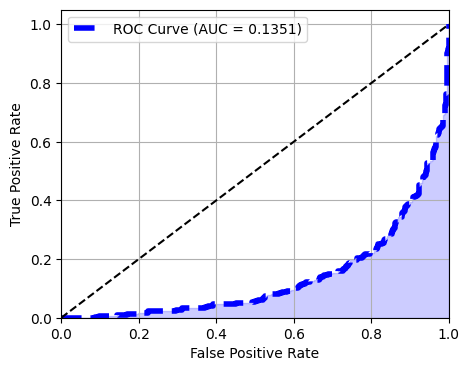

ROC AUC: 0.14


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Combine genuine and imposter scores for ROC curve calculation
y_true = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(imposter_scores)])
y_scores = np.concatenate([genuine_scores, imposter_scores])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', linestyle='--', linewidth=4, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue') # Shade the area under the ROC curve

plt.plot([0, 1], [0, 1], color='k', linestyle='--') # Random Guess with AUC = 0.5
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="best"), plt.grid()
plt.show()

print(f"ROC AUC: {roc_auc:.2f}")

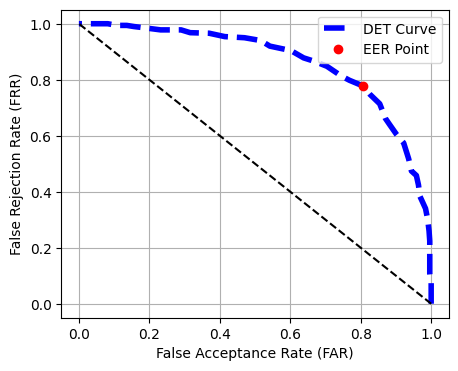

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(far_values, frr_values, linestyle="--", color='blue', linewidth=4, label="DET Curve")
if addedPlots is not None:
    addedPlots()
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
# plt.title('Detection Error Tradeoff (DET) curve')
plt.legend()
plt.grid()
plt.show()

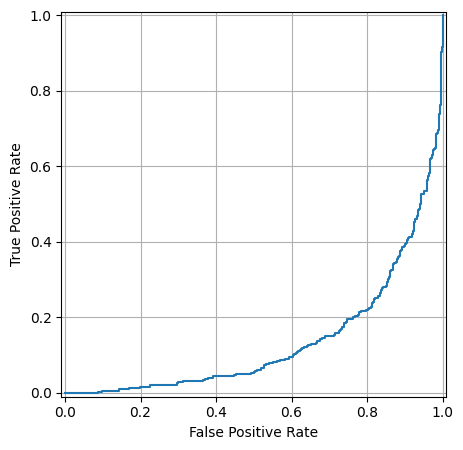

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay # Import RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming you have already calculated fpr, tpr, and thresholds using roc_curve
# fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

# Create the RocCurveDisplay object using fpr and tpr
display = RocCurveDisplay(fpr=fpr, tpr=tpr) # Use tpr instead of fnr

# Plot the ROC curve on the created axes
display.plot(ax=ax)  # Pass the axes to the plot method

# Add title and grid
# ax.set_title("Receiver Operating Characteristic (ROC) Curve")
ax.grid(True)
display.ax_.legend_.remove()

plt.show()

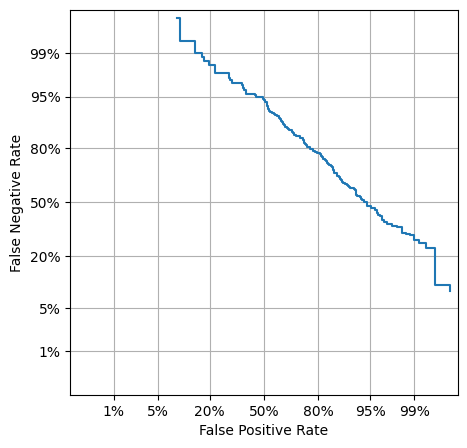

In [ ]:
from sklearn.metrics import det_curve, DetCurveDisplay
import matplotlib.pyplot as plt

# Calculate the False Positive Rate (FAR), True Positive Rate (TPR), and thresholds
fpr, fnr, thresholds = det_curve(y_true, y_scores)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

# Create the DetCurveDisplay object
display = DetCurveDisplay(fpr=fpr, fnr=fnr)

# Plot the DET curve on the created axes
display.plot(ax=ax)  # Pass the axes to the plot method

# Add title and grid
# ax.set_title("Detection Error Tradeoff (DET) Curve")
ax.grid(True)

plt.show()

# Reload the model

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# drive_path = "/content/drive/"
# !ls -l {drive_path}/MyDrive/Colab_Notebooks/

total 760
-rw------- 1 root root 742803 Dec 10 19:08 'Copy of ml-assignment-lstm-autoencoder.ipynb'
-rw------- 1 root root   9329 Nov 17 02:55  CV-Assignemnt2.ipynb
drwx------ 2 root root   4096 Oct 29  2023  MISC
drwx------ 2 root root   4096 Oct 31 13:03  psrs-ai-workshop
drwx------ 2 root root   4096 Oct 31 13:03  psrs-biometrics
drwx------ 2 root root   4096 Nov 17 15:26  psrs-computer-vision
drwx------ 2 root root   4096 Oct 29  2023  psrs-fourier-optics
drwx------ 2 root root   4096 Dec  9 03:13  psrs-machine-learning
-rw------- 1 root root    324 Dec 18 14:57  Untitled0.ipynb


In [ ]:
# Assuming your mounted drive is at /content/drive/MyDrive
# drive_path = "/content/drive/MyDrive"  # Replace with your actual mounted drive path if different

# List the contents of the mounted drive
# !ls -l {drive_path}

# If you want to see the contents of a specific directory within the drive:
# !ls -l {drive_path}/YourDirectoryName


#To list files recursively:
# !find "{drive_path}" -print

# To display files in a more user-friendly format:
# !tree "{drive_path}"

# To search for specific files within the drive
# !find "{drive_path}" -name "*.txt" -print #This will list all txt files

In [ ]:
# Check if the model variable exists and if it contains a Keras model
name_of_model = 'xception'

In [ ]:
model = load_model(f'./model/{name_of_model}.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 162 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# 4  Manual prediction

In [ ]:
from PIL import Image

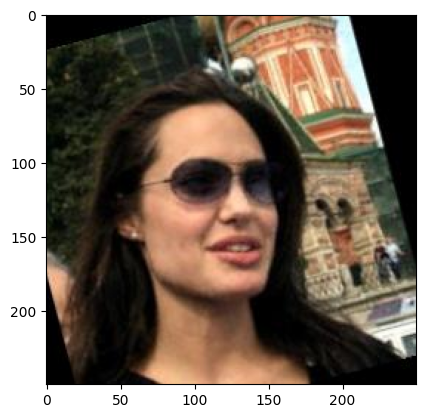

In [ ]:
fn = "./input/lfw-train-test-split/validation/Angelina_Jolie/Angelina_Jolie_0011.jpg"
# fn = './1.jpg'
image = Image.open(fn)
image = img_to_array(image)
plt.imshow(image/255.)

In [ ]:
image.shape

(250, 250, 3)

In [ ]:
image, _ = augment_valid(image[None],label='Serena_Williams')
image.shape

TensorShape([1, 128, 128, 3])

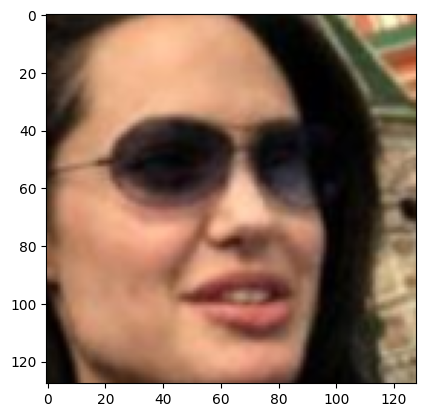

In [ ]:
plt.imshow(image[0]/255.)

In [ ]:
preds = model.predict(image)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


In [ ]:
# preds

In [ ]:
top = 5
top_indices = preds.argsort()[-top:][::-1]

In [ ]:
# top_indices

In [ ]:
# valid_dataset.class_names

In [ ]:
[(valid_dataset.class_names[i], preds[i]) for i in top_indices]

[('Angelina_Jolie', 0.99006677),
 ('Jennifer_Lopez', 0.0060492717),
 ('Rudolph_Giuliani', 0.00076989306),
 ('Guillermo_Coria', 0.00066777045),
 ('Tom_Daschle', 0.00039712247)]

# External Prediction

In [ ]:
def preprocess_to_lfw(image_path, output_size=(250, 250)):
    """
    Preprocess an image to resemble images in the LFW dataset.

    Args:
        image_path (str): Path to the input image.
        output_size (tuple): Desired output image size (width, height).

    Returns:
        np.ndarray: Preprocessed image array.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError("Image not found or invalid path.")

    # Convert the image to grayscale (optional, for LFW similarity)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load a face detector (Haar cascade or DNN-based detector)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        raise ValueError("No faces detected in the image.")

    # Extract the first detected face (LFW contains one face per image)
    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]

    # Align the face (assuming no complex landmark-based alignment here)
    # For more accuracy, use dlib or a similar library for facial landmark detection.

    # Resize to the standard LFW size
    resized_face = cv2.resize(face, output_size)

    # Normalize pixel intensity to 0-1 range
    normalized_face = resized_face # / 255.0

    # Convert from BGR to RGB
    normalized_face = cv2.cvtColor(normalized_face.astype(np.float32), cv2.COLOR_BGR2RGB)

    return normalized_face

In [ ]:
valid_dataset.class_names

['Alejandro_Toledo',
 'Andre_Agassi',
 'Angelina_Jolie',
 'Ariel_Sharon',
 'Arnold_Schwarzenegger',
 'Atal_Bihari_Vajpayee',
 'Bill_Clinton',
 'Carlos_Menem',
 'Colin_Powell',
 'David_Beckham',
 'George_W_Bush',
 'Gloria_Macapagal_Arroyo',
 'Guillermo_Coria',
 'Hamid_Karzai',
 'Hans_Blix',
 'Hugo_Chavez',
 'Igor_Ivanov',
 'Jack_Straw',
 'Jean_Chretien',
 'Jennifer_Aniston',
 'Jennifer_Lopez',
 'John_Ashcroft',
 'Jose_Maria_Aznar',
 'Juan_Carlos_Ferrero',
 'Junichiro_Koizumi',
 'Laura_Bush',
 'Lindsay_Davenport',
 'Lleyton_Hewitt',
 'Luiz_Inacio_Lula_da_Silva',
 'Megawati_Sukarnoputri',
 'Michael_Bloomberg',
 'Naomi_Watts',
 'Nestor_Kirchner',
 'Paul_Bremer',
 'Pete_Sampras',
 'Recep_Tayyip_Erdogan',
 'Ricardo_Lagos',
 'Roh_Moo-hyun',
 'Rudolph_Giuliani',
 'Saddam_Hussein',
 'Serena_Williams',
 'Tiger_Woods',
 'Tom_Daschle',
 'Tom_Ridge',
 'Tony_Blair',
 'Vladimir_Putin']

Image shape after preprocessing: (250, 250, 3)
The shape of the image to the model:  (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Top Predictions:
1. Atal_Bihari_Vajpayee           : 0.3603
2. Lindsay_Davenport              : 0.3388
3. Andre_Agassi                   : 0.1531
4. Angelina_Jolie                 : 0.0618
5. Arnold_Schwarzenegger          : 0.0119


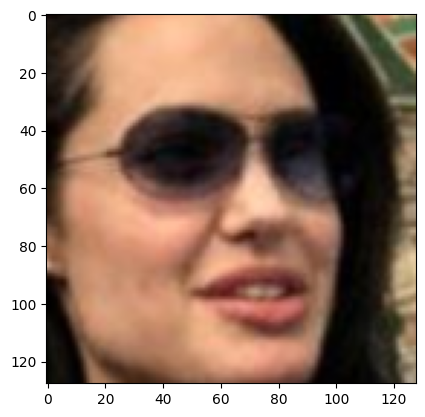

In [ ]:
# image_path = './8.jpg' # 3-selena,
image_path = "./input/lfw-train-test-split/validation/Angelina_Jolie/Angelina_Jolie_0011.jpg"

image = preprocess_to_lfw(image_path)

print(f"Image shape after preprocessing: {image.shape}")

plt.imshow(image/255.)

# Convert to TensorFlow tensor
image = tf.convert_to_tensor(image)

# Resize the image to (128, 128) using tf.image.resize
resized_image = tf.image.resize(image, [128, 128])

# Add a batch dimension using tf.expand_dims
image = tf.expand_dims(resized_image, axis=0) # Add batch dimension

print("The shape of the image to the model: ", image.shape)

plt.imshow(resized_image/255.) # Display the resized image

preds = model.predict(image) # Now predict using the image with the batch dimension
# preds is of shape (1, num_classes), so we need to extract the first row
preds = preds[0]  # Extract the first row to get predictions for the single image

top = 5
top_indices = preds.argsort()[-top:][::-1]

# Nicer display of predictions with uniform spacing and numbers
print("Top Predictions:")
for j, i in enumerate(top_indices, 1):  # Start numbering from 1
    class_name = valid_dataset.class_names[i]
    probability = preds[i]
    # Pad class names with spaces for alignment
    print(f"{j}. {class_name:{30}} : {probability:.4f}")

./2.jpg


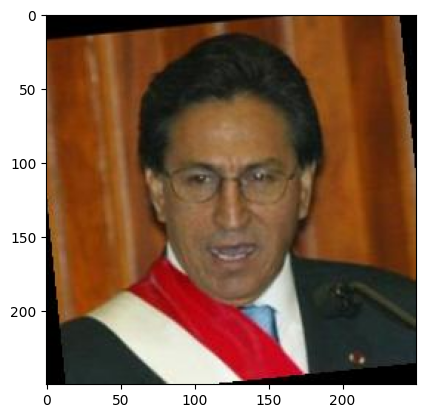

Image shape before preprocessing: (250, 250, 3)
Image shape after preprocessing: (1, 128, 128, 3)


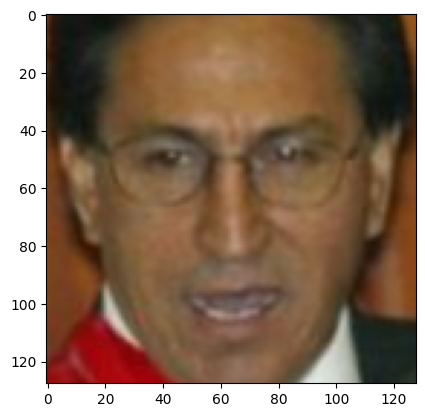

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
[('Alejandro_Toledo', 0.9999026), ('Tony_Blair', 2.8457513e-05), ('Vladimir_Putin', 1.9303194e-05), ('Jennifer_Aniston', 1.2841872e-05), ('Tiger_Woods', 1.1972671e-05)]


In [ ]:
#@title Manual Predition { display-mode: "form" }

image_path = './2.jpg' # serena-williams-victory.jpg
print(image_path)


image = Image.open(image_path)
image = img_to_array(image)
plt.imshow(image/255.)
plt.show()

print(f"Image shape before preprocessing: {image.shape}")

# Preprocess the image (same as manual prediction section)
image, _ = augment_valid(image[None], label=None) # No label is needed here

print(f"Image shape after preprocessing: {image.shape}")

plt.imshow(image[0]/255.)
plt.show()

preds = model.predict(image)[0]

top = 5
top_indices = preds.argsort()[-top:][::-1]
print([(valid_dataset.class_names[i], preds[i]) for i in top_indices])

In [ ]:
# prompt: a slider using jupyter widgets

# `embedding_extractor`

In [ ]:
# Get the output of the 'face_embedding' layer
embedding_out = model.get_layer('face_embedding').output

# Create a new model that takes the same input as the original model but outputs the embeddings
embedding_model = Model(inputs=model.input, outputs=embedding_out, name=f'{name_of_model}_embedding')

# Assuming 'image' is a preprocessed input image (same format as your training data)
# embeddings = embedding_model.predict(image)

Image shape after preprocessing: (250, 250, 3)


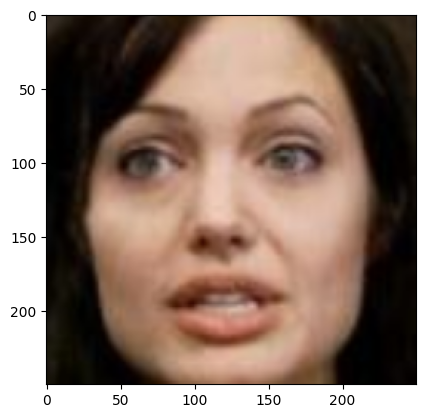

In [ ]:
img = preprocess_to_lfw('./input/lfw-train-test-split/validation/Angelina_Jolie/Angelina_Jolie_0008.jpg')

print(f"Image shape after preprocessing: {img.shape}")

plt.imshow(img/255.)

In [ ]:
# Convert to TensorFlow tensor
img = tf.convert_to_tensor(img)

# Resize the image to (128, 128) using tf.image.resize
resized_image = tf.image.resize(img, [128, 128])

# Add a batch dimension using tf.expand_dims
img = tf.expand_dims(resized_image, axis=0) # Add batch dimension

embeddings = embedding_model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


In [ ]:
emb_1 = embeddings

In [ ]:
emb_2 = embeddings

In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=f8eedc5c73270861dfe5b2b0ffbeab62a441ca1a2e9c919df12e3e3efad14cb8
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import face_recognition
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

results = face_recognition.compare_faces([emb_1], [emb_2])

RuntimeError: Error while calling cudaGetDevice(&the_device_id) in file /root/.cache/uv/sdists-v4/pypi/dlib/19.24.2/1nLar89_00oLAQW0yfxtD/dlib-19.24.2.tar.gz/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version

[array([[ 3.00009474e-02,  4.47844219e+00, -8.79980624e-02,
         -1.60650170e+00, -9.09991562e-02, -2.57007957e-01,
         -6.51708841e-02,  9.61965322e-02, -6.58482313e-02,
          1.68710828e-01,  5.93827106e-02, -1.55645359e+00,
          1.69221044e-01,  9.07862186e-02,  2.18540859e+00,
          1.02437191e-01, -5.96346483e-02,  7.82663107e-01,
         -1.74944055e+00,  2.18641497e-02,  1.03629336e-01,
         -6.94834888e-02,  1.02418728e-01,  4.57501054e-01,
          1.59455037e+00, -1.92885816e+00, -6.38211966e-02,
         -3.91863845e-02,  1.36956739e+00, -5.08561850e-01,
          5.74546196e-02,  1.07171440e+00, -1.06473804e-01,
         -3.41744646e-02, -1.74607098e+00, -1.93398428e+00,
         -6.70197845e-01, -6.06917627e-02,  3.53955477e-02,
          7.39036798e-02, -4.12187018e-02,  7.24776536e-02,
         -4.71137799e-02, -1.05108388e-01,  9.44933146e-02,
         -1.11209355e-01,  6.42806739e-02, -8.43122751e-02,
          7.09328279e-02, -7.30776712e-0